## Downsampling dense light curve under a cadence strategy

Developed by Xinyue Sheng (2021.06.28)

In [1]:
%load_ext autoreload
%autoreload 2

#Please enter your SciServer username between the single quotes below!
your_username = 'XinyueSheng'

# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

# import Eztao package for generating DRW and DHO light curves.
import eztao

# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# For the WFD footprint definitions
from lsst.sims.featureScheduler import utils as schedUtils

# import convenience functions
from opsimUtils import *

In [2]:
# Check avaiable database directoies
show_fbs_dirs()

['/home/idies/workspace/lsst_cadence/FBS_1.4/',
 '/home/idies/workspace/lsst_cadence/FBS_1.7/',
 '/home/idies/workspace/lsst_cadence/FBS_1.5/',
 '/home/idies/workspace/lsst_cadence/FBS_1.4.1/',
 '/home/idies/workspace/lsst_cadence/FBS_1.7.1/',
 '/home/idies/workspace/lsst_cadence/FBS_1.6/']

In [20]:
# specify path to the opsim database and create database object
# dbfile = '/home/idies/workspace/lsst_cadence/FBS_1.7/baseline_nexp1_v1.7_10yrs.db'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

dbRuns = show_opsims(dbDir)
dbRuns.sort() 

In [21]:
dbRuns

['baseline_nexp1_v1.7_10yrs',
 'baseline_nexp2_v1.7_10yrs',
 'cadence_drive_gl100_gcbv1.7_10yrs',
 'cadence_drive_gl100v1.7_10yrs',
 'cadence_drive_gl200_gcbv1.7_10yrs',
 'cadence_drive_gl200v1.7_10yrs',
 'cadence_drive_gl30_gcbv1.7_10yrs',
 'cadence_drive_gl30v1.7_10yrs',
 'ddf_dither0.00_v1.7_10yrs',
 'ddf_dither0.05_v1.7_10yrs',
 'ddf_dither0.10_v1.7_10yrs',
 'ddf_dither0.30_v1.7_10yrs',
 'ddf_dither0.70_v1.7_10yrs',
 'ddf_dither1.00_v1.7_10yrs',
 'ddf_dither1.50_v1.7_10yrs',
 'ddf_dither2.00_v1.7_10yrs',
 'euclid_dither1_v1.7_10yrs',
 'euclid_dither2_v1.7_10yrs',
 'euclid_dither3_v1.7_10yrs',
 'euclid_dither4_v1.7_10yrs',
 'euclid_dither5_v1.7_10yrs',
 'footprint_0_v1.710yrs',
 'footprint_1_v1.710yrs',
 'footprint_2_v1.710yrs',
 'footprint_3_v1.710yrs',
 'footprint_4_v1.710yrs',
 'footprint_5_v1.710yrs',
 'footprint_6_v1.710yrs',
 'footprint_7_v1.710yrs',
 'footprint_8_v1.710yrs',
 'pair_times_11_v1.7_10yrs',
 'pair_times_22_v1.7_10yrs',
 'pair_times_33_v1.7_10yrs',
 'pair_times_44

In [22]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
colors = {'u': 'cyan', 'g': 'g', 'r': 'y',
          'i': 'r', 'z': 'm', 'y': 'k'}

In [23]:
# Set RA, Dec for a single point in the sky.
# The input ra/dec values should be in DEGREES (even for v3 databases).
ra = [0.11]
dec = [-10.11]
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

mjdcol = 'observationStartMJD'
degrees = True

In [24]:
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', mjdcol])
slicer = slicers.UserPointsSlicer(
    ra, dec, lonCol='fieldRA', latCol='fieldDec', latLonDeg=degrees)
sql = 'filter = "r"'  # 'night < 365'
bundle = metricBundles.MetricBundle(metric, slicer, sql)
# In case you are using a dither stacker, we can check what columns are 
# actually being pulled from the database.
print(bundle.dbCols)

{'filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA'}


In [25]:
run ='rolling_scale0.9_nslice3_v1.7_10yrs'


In [26]:
bg = metricBundles.MetricBundleGroup(
    {0: bundle}, opSimDbs[run], outDir=outDir, resultsDb=resultDbs[run])
bg.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 452327 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [27]:
# Let's see what the "pass" metric provided, 
# looking at the first slicepoint (i.e. our ra/dec value).
print(bundle.metricValues.data[0].dtype.names)
# And look at some of the values.
# print(bundle.metricValues.data[0][0:10])
fulldata = bundle.metricValues.data[0]
# rdata = fulldata[fulldata.filter=='r']
print(fulldata[:10])
# Another way to access just the filter information..
# print(bundle.metricValues.data[0]['filter'][0:10])

('filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA')
[('r', 60994.07566245,  -9.17318573, 24.50824741, 358.93117134)
 ('r', 62350.30437384, -10.04213108, 23.52693218, 359.98802163)
 ('r', 62064.02558883, -11.27616311, 23.83546596, 359.99635994)
 ('r', 62064.06626795, -11.27616311, 24.30161822, 359.99635994)
 ('r', 60138.41496868,  -9.34954331, 23.90766809, 359.32897067)
 ('r', 60968.18774567, -11.38126704, 23.83793194, 359.16781396)
 ('r', 61650.25079054,  -9.13961076, 23.85585412, 358.95518398)
 ('r', 62708.41116563,  -9.86779715, 23.66255576, 359.30235415)
 ('r', 62384.32714644, -11.74652504, 23.64831939, 359.85519052)
 ('r', 62712.30728184,  -9.23566229, 23.54015548, 359.21752427)]


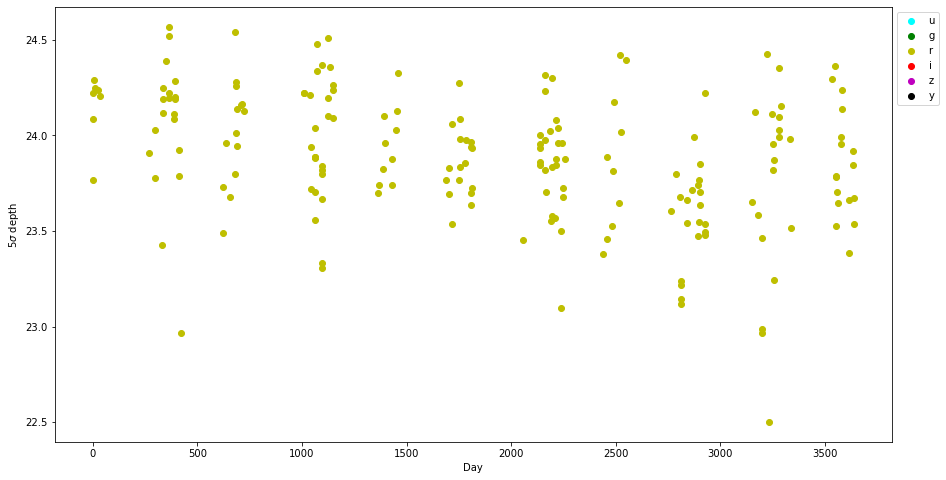

In [28]:
dayZero = bundle.metricValues.data[0][mjdcol].min()
plt.figure(figsize = (15,8))
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0][mjdcol][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [29]:
# Count up observations per filter.
print('%i Observations total at this point (All SNR levels)' % (
    bundle.metricValues.data[0].size))
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    print('%i Observations in %s' % (good[0].size, fname))

193 Observations total at this point (All SNR levels)
0 Observations in u
0 Observations in g
193 Observations in r
0 Observations in i
0 Observations in z
0 Observations in y


### Build Quasar metrics and generate light curve by DRW or DHO

In [2]:
%load_ext autoreload
%autoreload 2

#Please enter your SciServer username between the single quotes below!
your_username = 'XinyueSheng'

# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# For the WFD footprint definitions
from lsst.sims.featureScheduler import utils as schedUtils

# import convenience functions
from opsimUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Check avaiable database directoies
show_fbs_dirs()

['/home/idies/workspace/lsst_cadence/FBS_1.4/',
 '/home/idies/workspace/lsst_cadence/FBS_2.0/',
 '/home/idies/workspace/lsst_cadence/FBS_1.7/',
 '/home/idies/workspace/lsst_cadence/FBS_1.5/',
 '/home/idies/workspace/lsst_cadence/FBS_1.4.1/',
 '/home/idies/workspace/lsst_cadence/FBS_1.7.1/',
 '/home/idies/workspace/lsst_cadence/FBS_1.6/']

In [10]:
import numpy as np
import pandas as pd
from lsst.sims.maf.metrics import BaseMetric
import eztao
from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.ts import gpSimRand
from eztao.ts import drw_fit
from eztao.ts import gpSimFull, gpSimByTime
from eztao.ts.carma_fit import sample_carma

__all__ = ['QuasarMetric']

class QuasarMetric(BaseMetric):
    '''
    generate Quasar light curve by DRW or DHO
    '''
    def __init__(self, metricName = 'QuasarMetric', mjdCol = 'observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', LCparams = list, filterMag = dict):
        '''
        filterMag is a dict storing the mean mag for each band
        '''
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.filterMag = filterMag
        self.LCparams = LCparams
        self.lcInfo = None
        self.Denselc = None
        super().__init__(col = [self.mjdCol, self.m5Col, self.filterCol], 
                         metricName = metricName, units = 'mag')
    def lightCurve(self, time, m5, band):
        '''
        Calculate the magnitude of the object at each time, in each filter.
        LCparams: if you do DRW simulation, LCparams = [SF, TAU];
                  if you do DHO simulation, LCparams = [AR_list, MA_list]
        '''
        lcMags = np.zeros(time.size, dtype = float)
        LCparams = np.array(self.LCparams)
        if LCparams.shape == (2,):
            # if true, choose DRW kernel
            amp = LCparams[0]
            tau = LCparams[1]
            kernel = DRW_term(np.log(amp), np.log(tau))
        else:
            # false, choose DHO kernel
            ar = LCparams[0]
            ma = LCparams[1]
            kernel = DHO_term(np.log(ar[0]), np.log(ar[1]), np.log(ma[0]), np.log(ma[1]))
        duration = 365*10
        npts = 365*10*1000# 1000 observations per day, in order to keep mjd to round(3)
        SNR = 10
        np.random.seed(1)
        t, y, yerr = gpSimFull(kernel, SNR, duration, npts, log_flux=True)
        
        # delete Eztao-set error
        y = y - yerr
        
        # add mean mag
        y = y + self.filterMag[band]
        
        # store the dense light curve 
        self.Denselc = [t,y]
        
        # downsamped to purposed lsst cadence
        t, y, m5 = self.downsampeLC(time, m5, t, y)  
        
        # add lsst error
        y, yerr = self.lsst_noise(band, y, m5)
        
        return t, y, yerr
        
    def lsst_noise(self, band, mag, m5, gamma = 0.039, alpha_sys = 0.004):
        # add LSST noise
        x = 10**(0.4*(mag-m5))
        if band == 'u':
            gamma = 0.038
        alpha_rand_2 = (0.04-gamma)*x + gamma*(x**2)
        alpha_lsst_2 = alpha_sys**2+alpha_rand_2
        noise = np.random.normal(0,np.sqrt(alpha_lsst_2))
        return mag, noise
    
    def downsampeLC(self, cadence_mjds, m5, t, y):
        mjds_round3 = np.around(cadence_mjds, decimals = 3)
        t_round3 = np.around(t, decimals = 3)
        downsample_mjds, t_idx, c_idx = np.intersect1d(t_round3, mjds_round3, return_indices=True)

        return t[t_idx], y[t_idx], m5[c_idx]
    
    def run(self, dataSlice, slicePoint=None):
        surveyStart = dataSlice[self.mjdCol].min()
        time = dataSlice[self.mjdCol] - surveyStart
        time.sort()
        time = np.array(time)
        m5 = dataSlice[self.m5Col]
        band = dataSlice[self.filterCol][0]
        mjds, mag, mag_err = self.lightCurve(time, m5, band)
        self.lcInfo = [mjds, mag, mag_err]
        
         
        

/home/idies/lsst/stack/miniconda3-py38_4.9.2-0.4.3/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/metrics/baseMetric.py:39: UserWarning: Redefining metric __main__.QuasarMetric! (there are >1 metrics with the same name)
  warnings.warn('Redefining metric %s! (there are >1 metrics with the same name)' % (metricname))


In [5]:
# specify path to the opsim database and create database object
# dbfile = '/home/idies/workspace/lsst_cadence/FBS_1.7/baseline_nexp1_v1.7_10yrs.db'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir15 = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
dbDir17 = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs15, resultDbs15 = connect_dbs(dbDir15, outDir)
opSimDbs17, resultDbs17 = connect_dbs(dbDir17, outDir)

dbRuns = show_opsims(dbDir15) + show_opsims(dbDir17)
dbRuns.sort() 

In [6]:
# dbRuns
opSimDbs = opSimDbs15.copy()
opSimDbs.update(opSimDbs17)
resultDbs = resultDbs15.copy()
resultDbs.update(resultDbs17)

In [21]:
# opSimDbs

In [11]:

#parameter setting

# if DRW: [SF, TAU]
LCparams = np.array([0.17, 200])

# if DHO: [[ar], [ma]]
# ar = [0.334851147762757,0.00384145704148491]
# ma = [0.003672, 0.0257]
# LCparams = np.array([ar, ma])

# set mean mag for each filter
filterMag = {'u':22, 'g':22, 'r':22, 'i':22, 'z':22, 'y':22}

# select position
ra = 0
dec = -10

bands = ['u','g','r', 'i', 'z', 'y']

# choose a cadence strategy
run_list = ['baseline_nexp2_v1.7_10yrs',
           'u_long_ms_60_v1.7_10yrs',
           'cadence_drive_gl200_gcbv1.7_10yrs',
           'rolling_scale0.9_nslice3_v1.7_10yrs',
            'filterdist_indx4_v1.5_10yrs']

# build metric and gain light curve

lc_info = {}
dense_info = {}

for run in run_list:
    quasarSim = QuasarMetric(LCparams = LCparams, filterMag = filterMag)
    slicer = slicers.UserPointsSlicer(ra=[ra], dec=[dec] ,lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)
    lc_info[run] = []
    dense_info[run] = []
    for band in bands:
        constraint = 'filter = "{}"'.format(band) +  ' and note not like "DD%"'
        constraint += ' and proposalId = 1'
        agnmb = metricBundles.MetricBundle(quasarSim, slicer, constraint)
        bd = {'pointLC': agnmb}
        agnmb.setRunName(run)
        metricGroup = metricBundles.MetricBundleGroup({'agnmb':agnmb}, opSimDbs[run], outDir, resultDbs[run])
        metricGroup.runAll()
        lc_info[run].append(quasarSim.lcInfo)
        dense_info[run].append(quasarSim.Denselc)
    
    


Querying database SummaryAllProps with constraint filter = "u" and note not like "DD%" and proposalId = 1 for columns ['filter', 'fieldRA', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth']
Found 108080 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" and proposalId = 1 for columns ['filter', 'fieldRA', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth']
Found 157285 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and note not like "DD%" and proposalId = 1 for columns ['filter', 'fieldRA', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth']
Found 372075 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

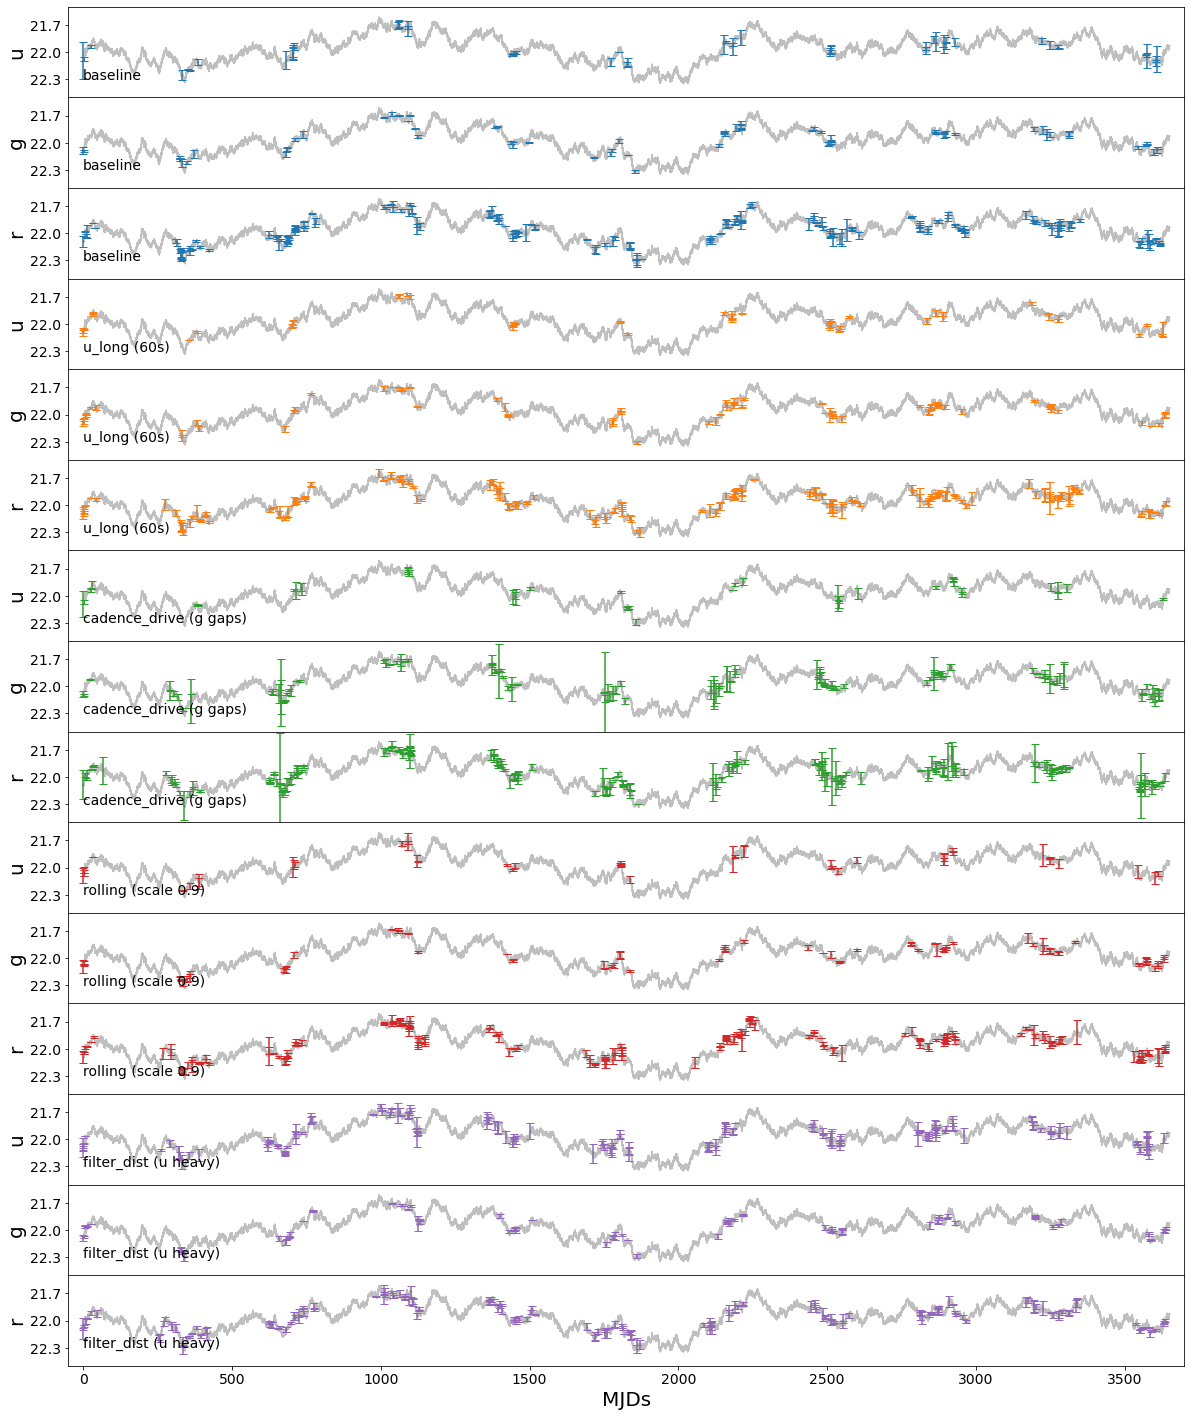

In [14]:

fig, axs = plt.subplots(15, 1, figsize=(20,25),sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})

# colorlist = ['mediumblue','mediumpurple','darkorchid','violet','palevioletred','lightpink']
colorlist = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

label_list = ['baseline', 'u_long (60s)', 'cadence_drive (g gaps)','rolling (scale 0.9)','filter_dist (u heavy)']
# band_list = ['r','u','g','r','u']



n = 0
for lc in lc_info:  
    for i in np.arange(3):
        info = lc_info[lc][i]
        dense = dense_info[lc][i]
        axs[n].plot(dense[0], dense[1], c = 'grey', alpha = 0.5)
        axs[n].errorbar(info[0], info[1], info[2], fmt='.', markersize='2', color = colorlist[int(n/3)], capsize=4, elinewidth=1.5)
        axs[n].text(0, 22.3,  s = label_list[int(n/3)], fontsize = 14)
        axs[n].invert_yaxis()
        axs[n].set_ylim([22.5,21.5])
        axs[n].set_yticks([22.3,22.0,21.7])
        axs[n].set_xlim([-50,3700])
        axs[n].tick_params(axis="x", labelsize=14)
        axs[n].tick_params(axis="y", labelsize=14)
        axs[n].set_xlabel('MJDs', fontsize = 20)
        axs[n].set_ylabel(bands[i], fontsize = 20)
        n += 1

        

In [12]:
lc_info

{'baseline_nexp2_v1.7_10yrs': [[array([0.00000000e+00, 1.90500052e+00, 2.68680074e+01, 3.31992091e+02,
          3.51934096e+02, 3.59963099e+02, 3.84869105e+02, 6.83105187e+02,
          7.03937193e+02, 7.03965193e+02, 7.03966193e+02, 7.09965195e+02,
          1.05903029e+03, 1.05995729e+03, 1.06008529e+03, 1.09187630e+03,
          1.09193230e+03, 1.44204340e+03, 1.44299940e+03, 1.44392940e+03,
          1.44693940e+03, 1.45393140e+03, 1.77507649e+03, 1.80097049e+03,
          1.82891350e+03, 1.83186050e+03, 2.15309259e+03, 2.16095259e+03,
          2.18190960e+03, 2.18294260e+03, 2.21092061e+03, 2.51101669e+03,
          2.51201769e+03, 2.51299069e+03, 2.51402169e+03, 2.83114778e+03,
          2.83114878e+03, 2.86007378e+03, 2.86416378e+03, 2.88999179e+03,
          2.89192979e+03, 2.89792279e+03, 2.89996779e+03, 2.92787680e+03,
          3.22307988e+03, 3.24798489e+03, 3.27592190e+03, 3.27793990e+03,
          3.57118798e+03, 3.57315998e+03, 3.57610098e+03, 3.60597699e+03,
         

In [20]:
def calculate_SF(mjd, flux):
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    return obs_SF_list, delta_list

def plot_obs_SF(obs_SF_list, delta_list, band, SF_inft):
   
    plt.figure(figsize = (10,6))
    plt.scatter(np.log10(np.array(delta_list)), obs_SF_list, s = 3, color = 'black', label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(np.log10(np.array(delta_list))), max(np.log10(np.array(delta_list))), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel(r'$log_{10}(\Delta t)$', fontsize=20)
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function', fontsize=20)
    plt.title('Structure Function (Observed) ' + band +' band',fontsize=20 )


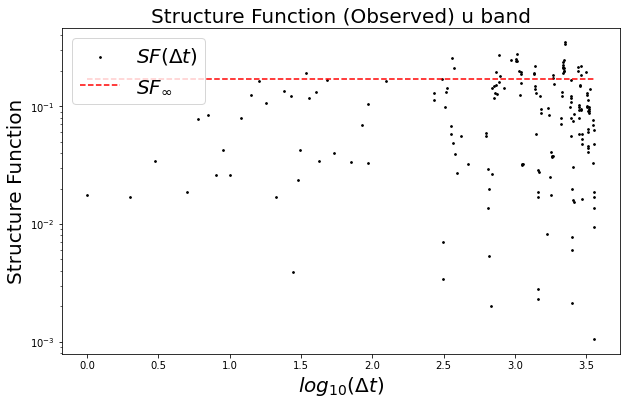

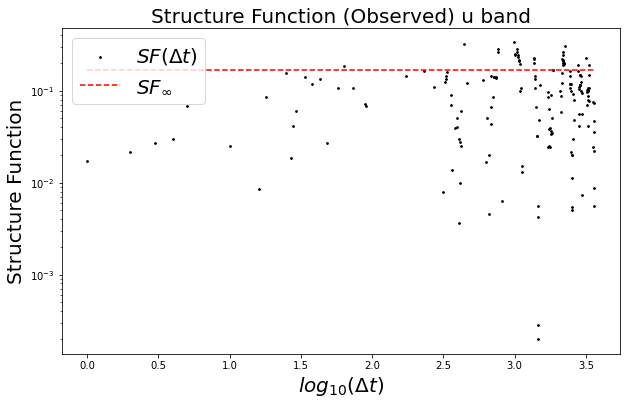

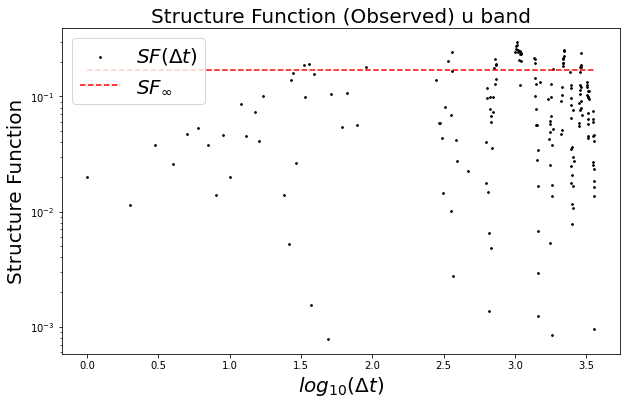

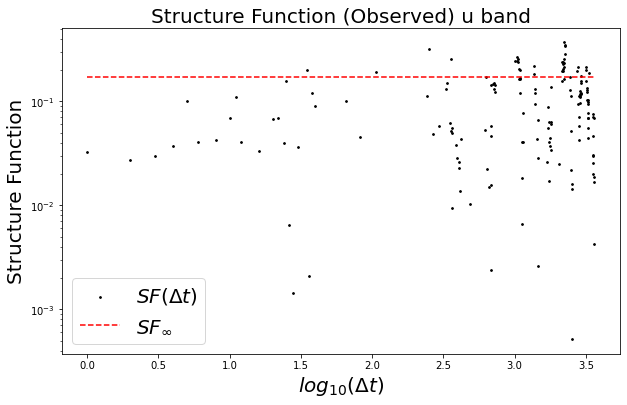

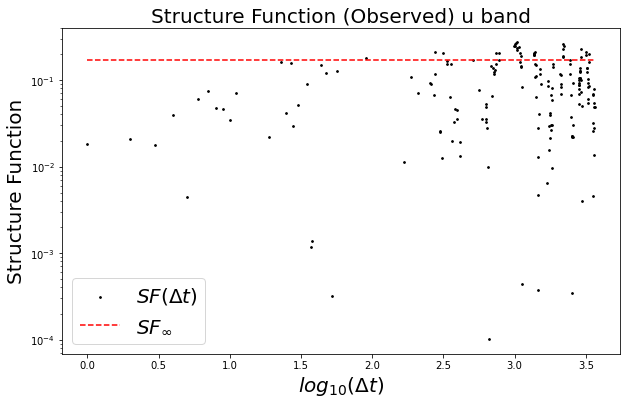

In [23]:
for lc in lc_info:  
    test = lc_info[lc][2]
    obs_SF_list, delta_list = calculate_SF(test[0], test[1])
    plot_obs_SF(obs_SF_list, delta_list, 'u', 0.17)

In [14]:
import numpy as np
import pandas as pd
from lsst.sims.maf.metrics import BaseMetric
import eztao
from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.ts import gpSimRand
from eztao.ts import drw_fit
from eztao.ts import gpSimFull, gpSimByTime
from eztao.ts.carma_fit import sample_carma

class CadenceScheme(BaseMetric):
    def __init__(self, metricName = 'CadenceScheme', mjdCol = 'observationStartMJD',
                 m5Col='fiveSigmaDepth',filterCol='filter'):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.lcInfo = list()
        super().__init__(col = [self.mjdCol, self.m5Col, self.filterCol], 
                         metricName = metricName, units = 'mag')
    def run(self, dataSlice, slicePoint=None):
        surveyStart = dataSlice[self.mjdCol].min()
        time = dataSlice[self.mjdCol] - surveyStart
        time.sort()
        m5 = dataSlice[self.m5Col]
        band = dataSlice[self.filterCol][0]
        self.lcInfo = [time.tolist(), m5.tolist()]

In [15]:
#parameter setting

# if DRW: [SF, TAU]
# LCparams = np.array([0.17, 200])

# if DHO: [[ar], [ma]]
# ar = [0.334851147762757,0.00384145704148491]
# ma = [0.003672, 0.0257]
# LCparams = np.array([ar, ma])

# set mean mag for each filter
filterMag = {'u':22, 'g':22, 'r':22, 'i':22, 'z':22, 'y':22}

# select position
ra = 0
dec = -10

bands = ['u','g','r', 'i', 'z', 'y']

# choose a cadence strategy
run_list = ['baseline_nexp2_v1.7_10yrs',
           'u_long_ms_60_v1.7_10yrs',
           'cadence_drive_gl200_gcbv1.7_10yrs',
           'rolling_scale0.9_nslice3_v1.7_10yrs',
            'filterdist_indx4_v1.5_10yrs']

# build metric and gain light curve

lc_info = {}

for run in run_list:
    quasarSim =  CadenceScheme()
    slicer = slicers.UserPointsSlicer(ra=[ra], dec=[dec] ,lonCol='fieldRA', latCol='fieldDec', latLonDeg=True)
    lc_info[run] = {}
    for band in bands:
        constraint = 'filter = "{}"'.format(band) +  ' and note not like "DD%"'
        constraint += ' and proposalId = 1'
        agnmb = metricBundles.MetricBundle(quasarSim, slicer, constraint)
        bd = {'pointLC': agnmb}
        agnmb.setRunName(run)
        metricGroup = metricBundles.MetricBundleGroup({'agnmb':agnmb}, opSimDbs[run], outDir, resultDbs[run])
        metricGroup.runAll()
        lc_info[run][band] = quasarSim.lcInfo

Querying database SummaryAllProps with constraint filter = "u" and note not like "DD%" and proposalId = 1 for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA']
Found 108080 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" and proposalId = 1 for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA']
Found 157285 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and note not like "DD%" and proposalId = 1 for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA']
Found 372075 visits
Running:  ['agnmb']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary

In [16]:
import json
# lc_info

with open("cadenceScheme.json", "w") as outfile:
    json.dump(lc_info, outfile)

(3, 70)

144.50769361605163